In [ ]:
%matplotlib inline
import datetime
import os
from scipy import misc
from scipy import ndimage
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageSequence
import cv2
import shutil
import random
from matplotlib import patches
import tensorflow as tf
import tqdm
from skimage import transform
import keras.preprocessing.image   # For using image generation
import skimage.io
import sklearn.model_selection
import skimage.transform           
import skimage.morphology       
import pandas as pd
import matplotlib.cm as cm         # Color map
IMG_DIR = '../Data/Resized/'
MASK_DIR = '../Data/masks/'
ANNOTATION_DIR = '../Data/SD_DATA/Annotations/'
IMG_HEIGHT = 384
IMG_WIDTH = 384
IMG_CHANNELS = 3      # Default number of channels
CW_DIR = os.getcwd()  

In [37]:
def getBoundingBox(filename):
    filename = filename.split('.')[0] + '.txt'
    rects = []
    with open(ANNOTATION_DIR +filename) as f:
        for line in f:
            xy=line.split(' ')
            xy = [int(i) for i in xy]
            center = (np.abs(xy[2]-xy[0]),np.abs(xy[3]-xy[1]))
            width = center[0]
            height = center[1]
            center = (xy[0],xy[1])
            rect = patches.Rectangle(center,width,height,linewidth=1,edgecolor='r',facecolor='none')
            rects.append(rect)
    return rects
            

In [ ]:
def load_raw_data(image_size=(IMG_HEIGHT, IMG_WIDTH)):
    x_train, y_train, x_test = [],[],[]

    for sub, dirs, files in os.walk(IMG_DIR):
        test_percentage = len(files)//10
        count = 0
        for f in files:
            img = misc.imread(sub + f)
            #img = open_and_close(img)
            img = misc.imresize(img,image_size)
            img = np.stack((img,)*3, -1)
            mask = misc.imread(MASK_DIR + f)
            mask = misc.imresize(mask,image_size)
            if count < test_percentage:
                x_test.append(img)
            else:
                
                x_train.append(img)
                y_train.append(mask)
            count+=1

    # Transform lists into 4-dim numpy arrays.
    x_train = np.array(x_train)
    y_train = np.expand_dims(np.array(y_train), axis=4)
    x_test = np.array(x_test)

    print('x_train.shape: {} of dtype {}'.format(x_train.shape, x_train.dtype))
    print('y_train.shape: {} of dtype {}'.format(y_train.shape, x_train.dtype))
    print('x_test.shape: {} of dtype {}'.format(x_test.shape, x_test.dtype))

    
    return x_train, y_train, x_test

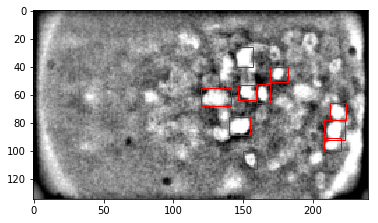

In [38]:
a=misc.imread('../Data/Resized/84.png')
#plt.imshow(a,cmap="gray")# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(a,cmap="gray")

# Create a Rectangle patch
rects = getBoundingBox('84.png')
for rect in rects:
    # Add the patch to the Axes
    ax.add_patch(rect)

plt.show()

In [31]:
for dirs, subdirs, files in os.walk('../Data/SD_DATA/newholding/'):
    for f in files:
        a = misc.imread(dirs+f)
        b = misc.imresize(a,(135,240))
        misc.imsave('../Data/Resized/'+f,b)

In [33]:
getBoundingBox('84.png')

[146, 53, 159, 64, 1]
[160, 52, 169, 66, 1]
[169, 40, 182, 51, 1]
[212, 66, 224, 78, 1]
[140, 76, 155, 89, 1]
[150, 100, 160, 113, 1]
[208, 78, 223, 92, 1]
[208, 91, 220, 100, 1]
[120, 55, 141, 68, 1]
[144, 26, 157, 40, 1]


In [83]:
def open_and_close(f,filename):
    img = misc.imread(filename)
    fig,ax = plt.subplots(3)
    img = img*(img>230)
    plt.subplot(221)
    rects = getBoundingBox(f)
    plt.imshow(img)
    img_bw = (255*(img>0)).astype('uint8')
    se1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    se2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    mask = cv2.morphologyEx(img_bw, cv2.MORPH_CLOSE, se1)
    plt.subplot(222,title='Mask1')
    plt.imshow(mask)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, se2)
    axe = plt.subplot(223,title='mask2')
    for rect in rects:
        # Add the patch to the Axes
        axe.add_patch(rect)
    plt.imshow(mask)
    plt.show()
def open_and_close(img):
    #img = img*(img>230)
    #img_bw = (255*(img>0)).astype('uint8')
    se1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    se2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    mask = cv2.morphologyEx(img_bw, cv2.MORPH_CLOSE, se1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, se2)
    return mask

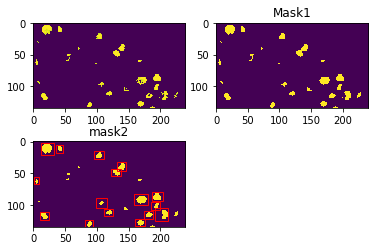

In [91]:
number = '234'
open_and_close(number+'.png','../Data/Resized/'+number+'.png')

In [97]:


def get_labeled_mask(mask, cutoff=.5):
    """Object segmentation by labeling the mask."""
    mask = mask.reshape(mask.shape[0], mask.shape[1])
    lab_mask = skimage.morphology.label(mask > cutoff) 
    
    # Keep only objects that are large enough.
    (mask_labels, mask_sizes) = np.unique(lab_mask, return_counts=True)
    if (mask_sizes < min_object_size).any():
        mask_labels = mask_labels[mask_sizes < min_object_size]
        for n in mask_labels:
            lab_mask[lab_mask == n] = 0
        lab_mask = skimage.morphology.label(lab_mask > cutoff) 
    
    return lab_mask  

def get_iou(y_true_labeled, y_pred_labeled):
    """Compute non-zero intersections over unions."""
    # Array of different objects and occupied area.
    (true_labels, true_areas) = np.unique(y_true_labeled, return_counts=True)
    (pred_labels, pred_areas) = np.unique(y_pred_labeled, return_counts=True)

    # Number of different labels.
    n_true_labels = len(true_labels)
    n_pred_labels = len(pred_labels)

    # Each mask has at least one identified object.
    if (n_true_labels > 1) and (n_pred_labels > 1):
        
        # Compute all intersections between the objects.
        all_intersections = np.zeros((n_true_labels, n_pred_labels))
        for i in range(y_true_labeled.shape[0]):
            for j in range(y_true_labeled.shape[1]):
                m = y_true_labeled[i,j]
                n = y_pred_labeled[i,j]
                all_intersections[m,n] += 1 

        # Assign predicted to true background.
        assigned = [[0,0]]
        tmp = all_intersections.copy()
        tmp[0,:] = -1
        tmp[:,0] = -1

        # Assign predicted to true objects if they have any overlap.
        for i in range(1, np.min([n_true_labels, n_pred_labels])):
            mn = list(np.unravel_index(np.argmax(tmp), (n_true_labels, n_pred_labels)))
            if all_intersections[mn[0], mn[1]] > 0:
                assigned.append(mn)
            tmp[mn[0],:] = -1
            tmp[:,mn[1]] = -1
        assigned = np.array(assigned)

        # Intersections over unions.
        intersection = np.array([all_intersections[m,n] for m,n in assigned])
        union = np.array([(true_areas[m] + pred_areas[n] - all_intersections[m,n]) 
                           for m,n in assigned])
        iou = intersection / union

        # Remove background.
        iou = iou[1:]
        assigned = assigned[1:]
        true_labels = true_labels[1:]
        pred_labels = pred_labels[1:]

        # Labels that are not assigned.
        true_not_assigned = np.setdiff1d(true_labels, assigned[:,0])
        pred_not_assigned = np.setdiff1d(pred_labels, assigned[:,1])
        
    else:
        # in case that no object is identified in one of the masks
        iou = np.array([])
        assigned = np.array([])
        true_labels = true_labels[1:]
        pred_labels = pred_labels[1:]
        true_not_assigned = true_labels
        pred_not_assigned = pred_labels
        
    # Returning parameters.
    params = {'iou': iou, 'assigned': assigned, 'true_not_assigned': true_not_assigned,
             'pred_not_assigned': pred_not_assigned, 'true_labels': true_labels,
             'pred_labels': pred_labels}
    return params

def get_score_summary(y_true, y_pred):
    """Compute the score for a single sample including a detailed summary."""
    
    y_true_labeled = get_labeled_mask(y_true)  
    y_pred_labeled = get_labeled_mask(y_pred)  
    
    params = get_iou(y_true_labeled, y_pred_labeled)
    iou = params['iou']
    assigned = params['assigned']
    true_not_assigned = params['true_not_assigned']
    pred_not_assigned = params['pred_not_assigned']
    true_labels = params['true_labels']
    pred_labels = params['pred_labels']
    n_true_labels = len(true_labels)
    n_pred_labels = len(pred_labels)

    summary = []
    for i,threshold in enumerate(np.arange(0.5, 1.0, 0.05)):
        tp = np.sum(iou > threshold)
        fn = n_true_labels - tp
        fp = n_pred_labels - tp
        if (tp+fp+fn)>0: 
            prec = tp/(tp+fp+fn)
        else: 
            prec = 0
        summary.append([threshold, prec, tp, fp, fn])

    summary = np.array(summary)
    score = np.mean(summary[:,1]) # Final score.
    params_dict = {'summary': summary, 'iou': iou, 'assigned': assigned, 
                   'true_not_assigned': true_not_assigned, 
                   'pred_not_assigned': pred_not_assigned, 'true_labels': true_labels,
                   'pred_labels': pred_labels, 'y_true_labeled': y_true_labeled,
                   'y_pred_labeled': y_pred_labeled}
    
    return score, params_dict

def get_score(y_true, y_pred):
    """Compute the score for a batch of samples."""
    scores = []
    for i in range(len(y_true)):
        score,_ = get_score_summary(y_true[i], y_pred[i])
        scores.append(score)
    return np.array(scores)

def plot_score_summary(y_true, y_pred):
    """Plot score summary for a single sample."""
    # Compute score and assign parameters.
    score, params_dict = get_score_summary(y_true, y_pred)
    
    assigned = params_dict['assigned']
    true_not_assigned = params_dict['true_not_assigned']
    pred_not_assigned = params_dict['pred_not_assigned']
    true_labels = params_dict['true_labels']
    pred_labels = params_dict['pred_labels']
    y_true_labeled = params_dict['y_true_labeled']
    y_pred_labeled = params_dict['y_pred_labeled']
    summary = params_dict['summary']

    n_assigned = len(assigned)
    n_true_not_assigned = len(true_not_assigned)
    n_pred_not_assigned = len(pred_not_assigned)
    n_true_labels = len(true_labels)
    n_pred_labels = len(pred_labels)

    # Summary dataframe.
    summary_df = pd.DataFrame(summary,columns=['threshold','precision','tp','fp','fn'])
    print('Final score:', score)
    print(summary_df)

    # Plots.
    fig, axs = plt.subplots(2,3,figsize=(20,13))

    # True mask with true objects.
    img = y_true
    axs[0,0].imshow(img, cmap=cm.gray)
    #axs[0,0].set_title('{}.) true mask: {} true objects'.format(n,train_df['num_masks'][n]))
    
    # True mask with identified objects.
    #img = np.zeros(y_true.shape)
    #img[y_true_labeled > 0.5] = 255
    img, img_type = imshow_args(y_true_labeled)
    axs[0,1].imshow(img, img_type)
    axs[0,1].set_title('{}.) true mask: {} objects identified'.format(n, n_true_labels))
    
    # Predicted mask with identified objects.
    #img = np.zeros(y_true.shape)
    #img[y_pred_labeled > 0.5] = 255
    img, img_type = imshow_args(y_pred_labeled)
    axs[0,2].imshow(img, img_type)
    axs[0,2].set_title('{}.) predicted mask: {} objects identified'.format(
        n, n_pred_labels))

    # Prediction overlap with true mask.
    img = np.zeros(y_true.shape)
    img[y_true > 0.5] = 100
    for i,j in assigned: img[(y_true_labeled == i) & (y_pred_labeled == j)] = 255
    axs[1,0].set_title('{}.) {} pred. overlaps (white) with true objects (gray)'.format(
        n,len(assigned)))
    axs[1,0].imshow(img, cmap='gray', norm=None)

    # Intersection over union.
    img = np.zeros(y_true.shape)
    img[(y_pred_labeled > 0) & (y_pred_labeled < 100)] = 100
    img[(y_true_labeled > 0) & (y_true_labeled < 100)] = 100
    for i,j in assigned: img[(y_true_labeled == i) & (y_pred_labeled == j)] = 255
    axs[1,1].set_title('{}.) {} intersections (white) over unions (gray)'.format(
        n, n_assigned))
    axs[1,1].imshow(img, cmap='gray');

    # False positives and false negatives.
    img = np.zeros(y_true.shape)
    for i in pred_not_assigned: img[(y_pred_labeled == i)] = 255
    for i in true_not_assigned: img[(y_true_labeled == i)] = 100
    axs[1,2].set_title('{}.) no threshold: {} fp (white), {} fn (gray)'.format(
        n, n_pred_not_assigned, n_true_not_assigned))
    axs[1,2].imshow(img, cmap='gray');


In [134]:
class NeuralNetwork():
    """ Implements a neural network.
        
        TensorFlow is used to implement the U-Net, which consists of convolutional
        and max pooling layers. Input and output shapes coincide. Methods are
        implemented to train the model, to save/load the complete session and to 
        attach summaries for visualization with TensorBoard. 
    """

    def __init__(self, nn_name='tmp', nn_type='UNet', log_step=0.2, keep_prob=0.33, 
                 mb_size=16, input_shape=[IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS], 
                 output_shape=[IMG_HEIGHT,IMG_WIDTH,1]):
        """Instance constructor."""
        
        # Tunable hyperparameters for training.
        self.mb_size = mb_size       # Mini batch size
        self.keep_prob = keep_prob   # Keeping probability with dropout regularization 
        self.learn_rate_step = 3     # Step size in terms of epochs
        self.learn_rate_alpha = 0.25 # Reduction of learn rate for each step 
        self.learn_rate_0 = 0.001    # Starting learning rate 
        self.dropout_proba = 0.1     # == 1-keep_probability
        
        # Set helper variables.
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.nn_type = nn_type                # Type of neural network
        self.nn_name = nn_name                # Name of neural network
        self.params = {}                      # For storing parameters
        self.learn_rate_pos = 0                
        self.learn_rate = self.learn_rate_0
        self.index_in_epoch = 0 
        self.epoch = 0. 
        self.log_step = log_step              # Log results in terms of epochs
        self.n_log_step = 0                   # Count number of mini batches  
        self.train_on_augmented_data = False  # True = use augmented data 
        self.use_tb_summary = False           # True = use TensorBoard summaries
        self.use_tf_saver = False             # True = save the session
        
        # Parameters that should be stored.
        self.params['train_loss']=[]
        self.params['valid_loss']=[]
        self.params['train_score']=[]
        self.params['valid_score']=[]
        
    def get_learn_rate(self):
        """Compute the current learning rate."""
        if False:
            # Fixed learnrate
            learn_rate = self.learn_rate_0
        else:
            # Decreasing learnrate each step by factor 1-alpha
            learn_rate = self.learn_rate_0*(1.-self.learn_rate_alpha)**self.learn_rate_pos
        return learn_rate

    def next_mini_batch(self):
        """Get the next mini batch."""
        start = self.index_in_epoch
        self.index_in_epoch += self.mb_size           
        self.epoch += self.mb_size/len(self.x_train)
        
        # At the start of the epoch.
        if start == 0:
            np.random.shuffle(self.perm_array) # Shuffle permutation array.
   
        # In case the current index is larger than one epoch.
        if self.index_in_epoch > len(self.x_train):
            self.index_in_epoch = 0
            self.epoch -= self.mb_size/len(self.x_train) 
            return self.next_mini_batch() # Recursive use of function.
        
        end = self.index_in_epoch
        
        # Original data.
        x_tr = self.x_train[self.perm_array[start:end]]
        y_tr = self.y_train[self.perm_array[start:end]]
        
        # Use augmented data.
        if self.train_on_augmented_data:
            x_tr, y_tr = generate_images_and_masks(x_tr, y_tr)
            y_tr = trsf_proba_to_binary(y_tr)
        
        return x_tr, y_tr
 
    def weight_variable(self, shape, name=None):
        """ Weight initialization """
        #initializer = tf.truncated_normal(shape, stddev=0.1)
        initializer = tf.contrib.layers.xavier_initializer()
        #initializer = tf.contrib.layers.variance_scaling_initializer()
        return tf.get_variable(name, shape=shape, initializer=initializer)

    def bias_variable(self, shape, name=None):
        """Bias initialization."""
        #initializer = tf.constant(0.1, shape=shape)  
        initializer = tf.contrib.layers.xavier_initializer()
        #initializer = tf.contrib.layers.variance_scaling_initializer()
        return tf.get_variable(name, shape=shape, initializer=initializer)
     
    def conv2d(self, x, W, name=None):
        """ 2D convolution. """
        return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME', name=name)

    def max_pool_2x2(self, x, name=None):
        """ Max Pooling 2x2. """
        return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME',
                              name=name)
    
    def conv2d_transpose(self, x, filters, name=None):
        """ Transposed 2d convolution. """
        return tf.layers.conv2d_transpose(x, filters=filters, kernel_size=2, 
                                          strides=2, padding='SAME') 
    
    def leaky_relu(self, z, name=None):
        """Leaky ReLU."""
        return tf.maximum(0.01 * z, z, name=name)
    
    def activation(self, x, name=None):
        """ Activation function. """
        a = tf.nn.elu(x, name=name)
        #a = self.leaky_relu(x, name=name)
        #a = tf.nn.relu(x, name=name)
        return a 
    
    def loss_tensor(self):
        """Loss tensor."""
        if True:
            # Dice loss based on Jaccard dice score coefficent.
            axis=np.arange(1,len(self.output_shape)+1)
            offset = 1e-5
            corr = tf.reduce_sum(self.y_data_tf * self.y_pred_tf, axis=axis)
            l2_pred = tf.reduce_sum(tf.square(self.y_pred_tf), axis=axis)
            l2_true = tf.reduce_sum(tf.square(self.y_data_tf), axis=axis)
            dice_coeff = (2. * corr + 1e-5) / (l2_true + l2_pred + 1e-5)
            # Second version: 2-class variant of dice loss
            #corr_inv = tf.reduce_sum((1.-self.y_data_tf) * (1.-self.y_pred_tf), axis=axis)
            #l2_pred_inv = tf.reduce_sum(tf.square(1.-self.y_pred_tf), axis=axis)
            #l2_true_inv = tf.reduce_sum(tf.square(1.-self.y_data_tf), axis=axis)
            #dice_coeff = ((corr + offset) / (l2_true + l2_pred + offset) +
            #             (corr_inv + offset) / (l2_pred_inv + l2_true_inv + offset))
            loss = tf.subtract(1., tf.reduce_mean(dice_coeff))
        if False:
            # Sigmoid cross entropy. 
            loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                    labels=self.y_data_tf, logits=self.z_pred_tf))
        return loss 
    
    def optimizer_tensor(self):
        """Optimization tensor."""
        # Adam Optimizer (adaptive moment estimation). 
        optimizer = tf.train.AdamOptimizer(self.learn_rate_tf).minimize(
                    self.loss_tf, name='train_step_tf')
        return optimizer
   
    def batch_norm_layer(self, x, name=None):
        """Batch normalization layer."""
        if False:
            layer = tf.layers.batch_normalization(x, training=self.training_tf, 
                                                  momentum=0.9, name=name)
        else: 
            layer = x
        return layer
    
    def dropout_layer(self, x, name=None):
        """Dropout layer."""
        if False:
            layer = tf.layers.dropout(x, self.dropout_proba, training=self.training_tf,
                                     name=name)
        else:
            layer = x
        return layer

    def num_of_weights(self,tensors):
        """Compute the number of weights."""
        sum_=0
        for i in range(len(tensors)):
            m = 1
            for j in range(len(tensors[i].shape)):
              m *= int(tensors[i].shape[j])
            sum_+=m
        return sum_

    def build_UNet_graph(self):
        """ Create the UNet graph in TensorFlow. """
        # 1. unit 
        with tf.name_scope('1.unit'):
            W1_1 = self.weight_variable([3,3,self.input_shape[2],16], 'W1_1')
            b1_1 = self.bias_variable([16], 'b1_1')
            Z1 = self.conv2d(self.x_data_tf, W1_1, 'Z1') + b1_1
            A1 = self.activation(self.batch_norm_layer(Z1)) # (.,128,128,16)
            A1_drop = self.dropout_layer(A1)
            W1_2 = self.weight_variable([3,3,16,16], 'W1_2')
            b1_2 = self.bias_variable([16], 'b1_2')
            Z2 = self.conv2d(A1_drop, W1_2, 'Z2') + b1_2
            A2 = self.activation(self.batch_norm_layer(Z2)) # (.,128,128,16)
            P1 = self.max_pool_2x2(A2, 'P1') # (.,64,64,16)
        # 2. unit 
        with tf.name_scope('2.unit'):
            W2_1 = self.weight_variable([3,3,16,32], "W2_1")
            b2_1 = self.bias_variable([32], 'b2_1')
            Z3 = self.conv2d(P1, W2_1) + b2_1
            A3 = self.activation(self.batch_norm_layer(Z3)) # (.,64,64,32)
            A3_drop = self.dropout_layer(A3)
            W2_2 = self.weight_variable([3,3,32,32], "W2_2")
            b2_2 = self.bias_variable([32], 'b2_2')
            Z4 = self.conv2d(A3_drop, W2_2) + b2_2
            A4 = self.activation(self.batch_norm_layer(Z4)) # (.,64,64,32)
            P2 = self.max_pool_2x2(A4) # (.,32,32,32)
        # 3. unit
        with tf.name_scope('3.unit'):
            W3_1 = self.weight_variable([3,3,32,64], "W3_1")
            b3_1 = self.bias_variable([64], 'b3_1')
            Z5 = self.conv2d(P2, W3_1) + b3_1
            A5 = self.activation(self.batch_norm_layer(Z5)) # (.,32,32,64)
            A5_drop = self.dropout_layer(A5)
            W3_2 = self.weight_variable([3,3,64,64], "W3_2")
            b3_2 = self.bias_variable([64], 'b3_2')
            Z6 = self.conv2d(A5_drop, W3_2) + b3_2
            A6 = self.activation(self.batch_norm_layer(Z6)) # (.,32,32,64)
            P3 = self.max_pool_2x2(A6) # (.,16,16,64)
        # 4. unit
        with tf.name_scope('4.unit'):
            W4_1 = self.weight_variable([3,3,64,128], "W4_1")
            b4_1 = self.bias_variable([128], 'b4_1')
            Z7 = self.conv2d(P3, W4_1) + b4_1
            A7 = self.activation(self.batch_norm_layer(Z7)) # (.,16,16,128)
            A7_drop = self.dropout_layer(A7)
            W4_2 = self.weight_variable([3,3,128,128], "W4_2")
            b4_2 = self.bias_variable([128], 'b4_2')
            Z8 = self.conv2d(A7_drop, W4_2) + b4_2
            A8 = self.activation(self.batch_norm_layer(Z8)) # (.,16,16,128)
            P4 = self.max_pool_2x2(A8) # (.,8,8,128)
        # 5. unit 
        with tf.name_scope('5.unit'):
            W5_1 = self.weight_variable([3,3,128,256], "W5_1")
            b5_1 = self.bias_variable([256], 'b5_1')
            Z9 = self.conv2d(P4, W5_1) + b5_1
            A9 = self.activation(self.batch_norm_layer(Z9)) # (.,8,8,256)
            A9_drop = self.dropout_layer(A9)
            W5_2 = self.weight_variable([3,3,256,256], "W5_2")
            b5_2 = self.bias_variable([256], 'b5_2')
            Z10 = self.conv2d(A9_drop, W5_2) + b5_2
            A10 = self.activation(self.batch_norm_layer(Z10)) # (.,8,8,256)
        # 6. unit
        with tf.name_scope('6.unit'):
            W6_1 = self.weight_variable([3,3,256,128], "W6_1")
            b6_1 = self.bias_variable([128], 'b6_1')
            U1 = self.conv2d_transpose(A10, 128) # (.,16,16,128)
            U1 = tf.concat([U1, A8], 3) # (.,16,16,256)
            Z11 = self.conv2d(U1, W6_1) + b6_1
            A11 = self.activation(self.batch_norm_layer(Z11)) # (.,16,16,128)
            A11_drop = self.dropout_layer(A11)
            W6_2 = self.weight_variable([3,3,128,128], "W6_2")
            b6_2 = self.bias_variable([128], 'b6_2')
            Z12 = self.conv2d(A11_drop, W6_2) + b6_2
            A12 = self.activation(self.batch_norm_layer(Z12)) # (.,16,16,128)
        # 7. unit 
        with tf.name_scope('7.unit'):
            W7_1 = self.weight_variable([3,3,128,64], "W7_1")
            b7_1 = self.bias_variable([64], 'b7_1')
            U2 = self.conv2d_transpose(A12, 64) # (.,32,32,64)
            U2 = tf.concat([U2, A6],3) # (.,32,32,128)
            Z13 = self.conv2d(U2, W7_1) + b7_1
            A13 = self.activation(self.batch_norm_layer(Z13)) # (.,32,32,64)
            A13_drop = self.dropout_layer(A13)
            W7_2 = self.weight_variable([3,3,64,64], "W7_2")
            b7_2 = self.bias_variable([64], 'b7_2')
            Z14 = self.conv2d(A13_drop, W7_2) + b7_2
            A14 = self.activation(self.batch_norm_layer(Z14)) # (.,32,32,64)
        # 8. unit
        with tf.name_scope('8.unit'):
            W8_1 = self.weight_variable([3,3,64,32], "W8_1")
            b8_1 = self.bias_variable([32], 'b8_1')
            U3 = self.conv2d_transpose(A14, 32) # (.,64,64,32)
            U3 = tf.concat([U3, A4],3) # (.,64,64,64)
            Z15 = self.conv2d(U3, W8_1) + b8_1
            A15 = self.activation(self.batch_norm_layer(Z15)) # (.,64,64,32)
            A15_drop = self.dropout_layer(A15)
            W8_2 = self.weight_variable([3,3,32,32], "W8_2")
            b8_2 = self.bias_variable([32], 'b8_2')
            Z16 = self.conv2d(A15_drop, W8_2) + b8_2
            A16 = self.activation(self.batch_norm_layer(Z16)) # (.,64,64,32)
        # 9. unit 
        with tf.name_scope('9.unit'):
            W9_1 = self.weight_variable([3,3,32,16], "W9_1")
            b9_1 = self.bias_variable([16], 'b9_1')
            U4 = self.conv2d_transpose(A16, 16) # (.,128,128,16)
            U4 = tf.concat([U4, A2],3) # (.,128,128,32)
            Z17 = self.conv2d(U4, W9_1) + b9_1
            A17 = self.activation(self.batch_norm_layer(Z17)) # (.,128,128,16)
            A17_drop = self.dropout_layer(A17)
            W9_2 = self.weight_variable([3,3,16,16], "W9_2")
            b9_2 = self.bias_variable([16], 'b9_2')
            Z18 = self.conv2d(A17_drop, W9_2) + b9_2
            A18 = self.activation(self.batch_norm_layer(Z18)) # (.,128,128,16)
        # 10. unit: output layer
        with tf.name_scope('10.unit'):
            W10 = self.weight_variable([1,1,16,1], "W10")
            b10 = self.bias_variable([1], 'b10')
            Z19 = self.conv2d(A18, W10) + b10
            A19 = tf.nn.sigmoid(self.batch_norm_layer(Z19)) # (.,128,128,1)
        
        self.z_pred_tf = tf.identity(Z19, name='z_pred_tf') # (.,128,128,1)
        self.y_pred_tf = tf.identity(A19, name='y_pred_tf') # (.,128,128,1)
        
        print('Build UNet Graph: 10 layers, {} trainable weights'.format(
            self.num_of_weights([W1_1,b1_1,W1_2,b1_2,W2_1,b2_1,W2_2,b2_2,
                                 W3_1,b3_1,W3_2,b3_2,W4_1,b4_1,W4_2,b4_2,
                                 W5_1,b5_1,W5_2,b5_2,W6_1,b6_1,W6_2,b6_2,
                                 W7_1,b7_1,W7_2,b7_2,W8_1,b8_1,W8_2,b8_2,
                                 W9_1,b9_1,W9_2,b9_2,W10,b10])))
    
    def build_graph(self):
        """ Build the complete graph in TensorFlow. """
        tf.reset_default_graph()  
        self.graph = tf.Graph()

        with self.graph.as_default():
            
            # Input tensor.
            shape = [None]
            shape = shape.extend(self.input_shape)
            self.x_data_tf = tf.placeholder(dtype=tf.float32, shape=shape, 
                                            name='x_data_tf') # (.,128,128,3)
            
            # Generic tensors.
            self.keep_prob_tf = tf.placeholder_with_default(1.0, shape=(), 
                                                            name='keep_prob_tf') 
            self.learn_rate_tf = tf.placeholder(dtype=tf.float32,
                                                name="learn_rate_tf")
            self.training_tf = tf.placeholder_with_default(False, shape=(),
                                                           name='training_tf')
            # Build U-Net graph.
            self.build_UNet_graph()

            # Target tensor.
            shape = [None]
            shape = shape.extend(self.output_shape)
            self.y_data_tf = tf.placeholder(dtype=tf.float32, shape=shape, 
                                            name='y_data_tf') # (.,128,128,1)
            # Loss tensor
            self.loss_tf = tf.identity(self.loss_tensor(), name='loss_tf')

            # Optimisation tensor.
            self.train_step_tf = self.optimizer_tensor()
            
            # Extra operations required for batch normalization.
            self.extra_update_ops_tf = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

            
    def train_graph(self, sess, x_train, y_train, x_valid, y_valid, n_epoch=1, 
                    train_on_augmented_data=False):
        """ Train the graph of the corresponding neural network. """
        # Set training and validation sets.
        self.x_train = x_train
        self.y_train = y_train
        self.x_valid = x_valid
        self.y_valid = y_valid
        
        # Parameters.
        self.perm_array = np.arange(len(self.x_train))
        self.train_on_augmented_data = train_on_augmented_data
        mb_per_epoch = self.x_train.shape[0]/self.mb_size
        train_loss, train_score, valid_loss, valid_score = [],[],[],[]
        
        # Start timer.
        start = datetime.datetime.now()
        print('Training the Neural Network')
        print('\tnn_name = {}, n_epoch = {}, mb_size = {}, learnrate = {:.7f}'.format(
               self.nn_name, n_epoch, self.mb_size, self.learn_rate))
        print('\tinput_shape = {}, output_shape = {}'.format(
            self.input_shape, self.output_shape))
        print('\tlearn_rate = {:.10f}, learn_rate_0 = {:.10f}, learn_rate_alpha = {}'.format(
            self.learn_rate, self.learn_rate_0, self.learn_rate_alpha))
        print('\tlearn_rate_step = {}, learn_rate_pos = {}, dropout_proba = {}'.format(
            self.learn_rate_step, self.learn_rate_pos, self.dropout_proba))
        print('\tx_train = {}, x_valid = {}'.format(x_train.shape, x_valid.shape))
        print('\ty_train = {}, y_valid = {}'.format(y_train.shape, y_valid.shape))
        print('Training started: {}'.format(datetime.datetime.now().strftime(
                                     '%d-%m-%Y %H:%M:%S')))
        
        # Looping over mini batches.
        for i in range(int(n_epoch*mb_per_epoch)+1):

            # Adapt the learning rate.
            if not self.learn_rate_pos == int(self.epoch // self.learn_rate_step):
                self.learn_rate_pos = int(self.epoch // self.learn_rate_step)
                self.learn_rate = self.get_learn_rate()
                print('Update learning rate to {:.10f}. Running time: {}'.format(
                    self.learn_rate, datetime.datetime.now()-start))
            
            # Train the graph.
            x_batch, y_batch = self.next_mini_batch() # next mini batch
            sess.run([self.train_step_tf, self.extra_update_ops_tf], 
                     feed_dict={self.x_data_tf: x_batch, self.y_data_tf: y_batch, 
                                self.keep_prob_tf: self.keep_prob, 
                                self.learn_rate_tf: self.learn_rate,
                                self.training_tf: True})
            
            # Store losses and scores.
            if i%int(self.log_step*mb_per_epoch) == 0:
             
                self.n_log_step += 1 # Current number of log steps.
                
                # Train data used for evaluation.
                ids = np.arange(len(self.x_train))
                np.random.shuffle(ids)
                ids = ids[:len(x_valid)] # len(x_batch)
                x_trn = self.x_train[ids]
                y_trn = self.y_train[ids]
                
                # Valid data used for evaluation.
                ids = np.arange(len(self.x_valid))
                np.random.shuffle(ids)
                ids = ids[:len(x_valid)] # len(x_batch)
                x_vld = self.x_valid[ids]
                y_vld = self.y_valid[ids]
                
                feed_dict_train = {self.x_data_tf: x_trn, self.y_data_tf: y_trn, 
                                   self.keep_prob_tf: 1.0}
                feed_dict_valid = {self.x_data_tf: x_vld, self.y_data_tf: y_vld, 
                                   self.keep_prob_tf: 1.0}
                
                # Evaluate current loss and score
                train_loss, y_train_pred = sess.run([self.loss_tf, self.y_pred_tf], 
                                                   feed_dict = feed_dict_train)
                valid_loss, y_valid_pred = sess.run([self.loss_tf, self.y_pred_tf], 
                                                   feed_dict = feed_dict_valid)
                train_score = np.mean(get_score(y_trn, y_train_pred))
                valid_score = np.mean(get_score(y_vld, y_valid_pred))
                
                print(('{:.2f} epoch: train/valid loss = {:.4f}/{:.4f} ' + 
                       'train/valid score = {:.4f}/{:.4f}').format(
                        self.epoch, train_loss, valid_loss,  train_score, valid_score))

                # Store losses and scores.
                self.params['train_loss'].extend([train_loss])
                self.params['valid_loss'].extend([valid_loss])
                self.params['train_score'].extend([train_score])
                self.params['valid_score'].extend([valid_score])
        
                # Save summaries for TensorBoard.
                if self.use_tb_summary:
                    train_summary = sess.run(self.merged, feed_dict = feed_dict_train)
                    valid_summary = sess.run(self.merged, feed_dict = feed_dict_valid)
                    self.train_writer.add_summary(train_summary, self.n_log_step)
                    self.valid_writer.add_summary(valid_summary, self.n_log_step)
                
        # Store parameters.
        self.params['learn_rate'] = self.learn_rate
        self.params['learn_rate_step'] = self.learn_rate_step
        self.params['learn_rate_pos'] = self.learn_rate_pos
        self.params['learn_rate_alpha'] = self.learn_rate_alpha
        self.params['learn_rate_0'] = self.learn_rate_0
        self.params['keep_prob'] = self.keep_prob
        self.params['epoch'] = self.epoch
        self.params['n_log_step'] = self.n_log_step
        self.params['log_step'] = self.log_step
        self.params['input_shape'] = self.input_shape
        self.params['output_shape'] = self.output_shape
        self.params['mb_size'] = self.mb_size
        self.params['dropout_proba'] = self.dropout_proba
        
        print('Training ended. Running time: {}'.format(datetime.datetime.now()-start))
    
    def summary_variable(self, var, var_name):
        """ Attach summaries to a tensor for TensorBoard visualization. """
        with tf.name_scope(var_name):
            mean = tf.reduce_mean(var)
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
            tf.summary.scalar('mean', mean)
            tf.summary.scalar('stddev', stddev)
            tf.summary.scalar('max', tf.reduce_max(var))
            tf.summary.scalar('min', tf.reduce_min(var))
            tf.summary.histogram('histogram', var)

    def attach_summary(self, sess):
        """ Attach TensorBoard summaries to certain tensors. """
        self.use_tb_summary = True
        
        # Create summary tensors for TensorBoard.
        tf.summary.scalar('loss_tf', self.loss_tf)

        # Merge all summaries.
        self.merged = tf.summary.merge_all()

        # Initialize summary writer.
        timestamp = datetime.datetime.now().strftime('%d-%m-%Y_%H-%M-%S')
        filepath = os.path.join(os.getcwd(), LOGS_DIR_NAME, (self.nn_name+'_'+timestamp))
        self.train_writer = tf.summary.FileWriter(os.path.join(filepath,'train'), sess.graph)
        self.valid_writer = tf.summary.FileWriter(os.path.join(filepath,'valid'), sess.graph)

    def attach_saver(self):
        """ Initialize TensorFlow saver. """
        with self.graph.as_default():
            self.use_tf_saver = True
            self.saver_tf = tf.train.Saver()

    def save_model(self, sess):
        """ Save parameters, tensors and summaries. """
        if not os.path.isdir(os.path.join(CW_DIR, SAVES_DIR_NAME)):
            os.mkdir(SAVES_DIR_NAME)
        filepath = os.path.join(os.getcwd(), SAVES_DIR_NAME , self.nn_name+'_params.npy')
        np.save(filepath, self.params) # save parameters of the network

        # TensorFlow saver
        if self.use_tf_saver:
            filepath = os.path.join(os.getcwd(),  self.nn_name)
            self.saver_tf.save(sess, filepath)

        # TensorBoard summaries
        if self.use_tb_summary:
            self.train_writer.close()
            self.valid_writer.close()
        
    def load_session_from_file(self, filename):
        """ Load session from a file, restore the graph, and load the tensors. """
        tf.reset_default_graph()
        filepath = os.path.join(os.getcwd(), filename + '.meta')
        saver = tf.train.import_meta_graph(filepath)
        sess = tf.Session() # default session
        saver.restore(sess, filename) # restore session
        self.graph = tf.get_default_graph() # save default graph
        self.load_parameters(filename) # load parameters
        self.load_tensors(self.graph) # define relevant tensors as variables 
        return sess
    
    def load_parameters(self, filename):
        '''Load helper and tunable parameters.'''
        filepath = os.path.join(os.getcwd(), SAVES_DIR_NAME, filename+'_params.npy')
        self.params = np.load(filepath).item() # load parameters of network
        
        self.nn_name = filename
        self.learn_rate = self.params['learn_rate']
        self.learn_rate_0 = self.params['learn_rate_0']
        self.learn_rate_step = self.params['learn_rate_step']
        self.learn_rate_alpha = self.params['learn_rate_alpha']
        self.learn_rate_pos = self.params['learn_rate_pos']
        self.keep_prob = self.params['keep_prob']
        self.epoch = self.params['epoch'] 
        self.n_log_step = self.params['n_log_step']
        self.log_step = self.params['log_step']
        self.input_shape = self.params['input_shape']
        self.output_shape = self.params['output_shape'] 
        self.mb_size = self.params['mb_size']   
        self.dropout_proba = self.params['dropout_proba']
        
        print('Parameters of the loaded neural network')
        print('\tnn_name = {}, epoch = {:.2f}, mb_size = {}'.format(
            self.nn_name, self.epoch, self.mb_size))
        print('\tinput_shape = {}, output_shape = {}'.format(
            self.input_shape, self.output_shape))
        print('\tlearn_rate = {:.10f}, learn_rate_0 = {:.10f}, dropout_proba = {}'.format(
            self.learn_rate, self.learn_rate_0, self.dropout_proba))
        print('\tlearn_rate_step = {}, learn_rate_pos = {}, learn_rate_alpha = {}'.format(
            self.learn_rate_step, self.learn_rate_pos, self.learn_rate_alpha))

    def load_tensors(self, graph):
        """ Load tensors from a graph. """
        # Input tensors
        self.x_data_tf = graph.get_tensor_by_name("x_data_tf:0")
        self.y_data_tf = graph.get_tensor_by_name("y_data_tf:0")

        # Tensors for training and prediction.
        self.learn_rate_tf = graph.get_tensor_by_name("learn_rate_tf:0")
        self.keep_prob_tf = graph.get_tensor_by_name("keep_prob_tf:0")
        self.loss_tf = graph.get_tensor_by_name('loss_tf:0')
        self.train_step_tf = graph.get_operation_by_name('train_step_tf')
        self.z_pred_tf = graph.get_tensor_by_name('z_pred_tf:0')
        self.y_pred_tf = graph.get_tensor_by_name("y_pred_tf:0")
        self.training_tf = graph.get_tensor_by_name("training_tf:0")
        self.extra_update_ops_tf = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

    def get_prediction(self, sess, x_data, keep_prob=1.0):
        """ Prediction of the neural network graph. """
        return sess.run(self.y_pred_tf, feed_dict={self.x_data_tf: x_data,
                                                     self.keep_prob_tf: keep_prob})
       
    def get_loss(self, sess, x_data, y_data, keep_prob=1.0):
        """ Compute the loss. """
        return sess.run(self.loss_tf, feed_dict={self.x_data_tf: x_data, 
                                                 self.y_data_tf: y_data,
                                                 self.keep_prob_tf: keep_prob})

In [135]:
x_train,y_train,x_test = load_raw_data()
x_train,y_train,x_test = preprocess_raw_data(x_train,y_train,x_test)

In [136]:
def imshow_args(x):
    """Matplotlib imshow arguments for plotting."""
    if len(x.shape)==2: return x, cm.gray
    if x.shape[2]==1: return x[:,:,0], cm.gray
    return x, None

ValueError: Dimension 1 in both shapes must be equal, but are 18 and 17 for 'Unit6/concat' (op: 'ConcatV2') with input shapes: [?,18,30,128], [?,17,30,128], [] and with computed input tensors: input[2] = <3>.

In [ ]:
# Create and start training of a new neural network, or continue training of
# a pretrained model.
SEED = 123  
LOGS_DIR_NAME = 'logs'    # Folder name for TensorBoard summaries 
SAVES_DIR_NAME = 'saves'  # Folder name for storing network parameters
min_object_size=400
#nn_name = ['nn0','nn1','nn2','nn3','nn4','nn5','nn6','nn7','nn8','nn9']
#nn_name = ['nn0_128_128_3']  
#nn_name = ['nn0_384_384_3']  
#nn_name = ['nn0_512_512_3']  
nn_name = ['nn0_256_256_3']  

# Implement cross validations
cv_num = 10 
kfold = sklearn.model_selection.KFold(cv_num, shuffle=True, random_state=SEED)

for i,(train_index, valid_index) in enumerate(kfold.split(x_train)):

    # Start timer
    start = datetime.datetime.now();

    # Split into train and validation 
    x_trn = x_train[train_index]
    y_trn = y_train[train_index]
    x_vld = x_train[valid_index]
    y_vld = y_train[valid_index]
    
    # Choose a certain fold.
    if i==0:
        # Create and start training of a new model.
        if True:
            u_net = NeuralNetwork(nn_name=nn_name[0], log_step=1.0, input_shape=(384,384,3), 
                                  output_shape=(384,384,1)) # Create instance of neural network.
            u_net.build_graph() # Build graph.

            # Start tensorflow session.
            with tf.Session(graph=u_net.graph) as sess: 
                u_net.attach_saver() # Attach saver tensor.
                u_net.attach_summary(sess) # Attach summaries.
                sess.run(tf.global_variables_initializer()) # Variable initialization.

                # Training on original data.
                u_net.train_graph(sess, x_trn, y_trn, x_vld, y_vld, n_epoch=4.)

                for _ in range(1):
                    # Training on augmented data.
                    u_net.train_graph(sess, x_trn, y_trn, x_vld, y_vld, n_epoch=4.,
                                      train_on_augmented_data=True)
                    u_net.save_model(sess) # Save parameters, tensors, summaries.

        # Continue training of a pretrained model.
        if False:
            u_net = NeuralNetwork() 
            sess = u_net.load_session_from_file(nn_name[0])  
            u_net.attach_saver() 
            u_net.attach_summary(sess) 

            # Training on original data.
            #u_net.train_graph(sess, x_trn, y_trn, x_vld, y_vld, n_epoch=0.1) 

            for _ in range(9):
                # Training on augmented data.
                u_net.train_graph(sess, x_trn, y_trn, x_vld, y_vld, n_epoch=5.,
                                  train_on_augmented_data = True)
                u_net.save_model(sess) # Save parameters, tensors, summaries.

print('Total running time: ', datetime.datetime.now() - start)

In [ ]:
# Collection of methods for basic data manipulation like normalizing, inverting, 
# color transformation and generating new images/masks

def normalize_imgs(data):
    """Normalize images."""
    return normalize(data, type_=1)

def normalize_masks(data):
    """Normalize masks."""
    return normalize(data, type_=1)
    
def normalize(data, type_=1): 
    """Normalize data."""
    if type_==0:
        # Convert pixel values from [0:255] to [0:1] by global factor
        data = data.astype(np.float32) / data.max()
    if type_==1:
        # Convert pixel values from [0:255] to [0:1] by local factor
        div = data.max(axis=tuple(np.arange(1,len(data.shape))), keepdims=True) 
        div[div < 0.01*data.mean()] = 1. # protect against too small pixel intensities
        data = data.astype(np.float32)/div
    if type_==2:
        # Standardisation of each image 
        data = data.astype(np.float32) / data.max() 
        mean = data.mean(axis=tuple(np.arange(1,len(data.shape))), keepdims=True) 
        std = data.std(axis=tuple(np.arange(1,len(data.shape))), keepdims=True) 
        data = (data-mean)/std

    return data

def trsf_proba_to_binary(y_data):
    """Transform propabilities into binary values 0 or 1."""  
    return np.greater(y_data,.5).astype(np.uint8)

def invert_imgs(imgs, cutoff=.5):
    '''Invert image if mean value is greater than cutoff.'''
    imgs = np.array(list(map(lambda x: 1.-x if np.mean(x)>cutoff else x, imgs)))
    return normalize_imgs(imgs)

def imgs_to_grayscale(imgs):
    '''Transform RGB images into grayscale spectrum.''' 
    if imgs.shape[3]==3:
        imgs = normalize_imgs(np.expand_dims(np.mean(imgs, axis=3), axis=3))
    return imgs

def generate_images(imgs, seed=None):
    """Generate new images."""
    # Transformations.
    image_generator = keras.preprocessing.image.ImageDataGenerator(
        rotation_range = 90., width_shift_range = 0.02 , height_shift_range = 0.02,
        zoom_range = 0.10, horizontal_flip=True, vertical_flip=True)
    
    # Generate new set of images
    imgs = image_generator.flow(imgs, np.zeros(len(imgs)), batch_size=len(imgs),
                                shuffle = False, seed=seed).next()    
    return imgs[0]

def generate_images_and_masks(imgs, masks):
    """Generate new images and masks."""
    seed = np.random.randint(10000) 
    imgs = generate_images(imgs, seed=seed)
    masks = trsf_proba_to_binary(generate_images(masks, seed=seed))
    return imgs, masks

def preprocess_raw_data(x_train, y_train, x_test, grayscale=False, invert=False):
    """Preprocessing of images and masks."""
    # Normalize images and masks
    x_train = normalize_imgs(x_train)
    y_train = trsf_proba_to_binary(normalize_masks(y_train))
    x_test = normalize_imgs(x_test)
    print('Images normalized.')
 
    if grayscale:
        # Remove color and transform images into grayscale spectrum.
        x_train = imgs_to_grayscale(x_train)
        x_test = imgs_to_grayscale(x_test)
        print('Images transformed into grayscale spectrum.')

    if invert:
        # Invert images, such that each image has a dark background.
        x_train = invert_imgs(x_train)
        x_test = invert_imgs(x_test)
        print('Images inverted to remove light backgrounds.')

    return x_train, y_train, x_test
    

In [ ]:
# Show intermediate losses and scores during the training session.
#mn = 'nn0_512_512_3' 
mn = 'nn0_256_256_3' 
u_net = NeuralNetwork()
sess = u_net.load_session_from_file(mn)
sess.close()
train_loss = u_net.params['train_loss']
valid_loss = u_net.params['valid_loss']
train_score = u_net.params['train_score']
valid_score = u_net.params['valid_score']

print('final train/valid loss = {:.4f}/{:.4f}'.format(train_loss[-1], valid_loss[-1]))
print('final train/valid score = {:.4f}/{:.4f}'.format(train_score[-1], valid_score[-1]))
plt.figure(figsize=(10, 5));
plt.subplot(1,2,1)
plt.plot(np.arange(0,len(train_loss)), train_loss,'-b', label='Training')
plt.plot(np.arange(0,len(valid_loss)), valid_loss,'-g', label='Validation')
plt.legend(loc='lower right', frameon=False)
plt.ylim(ymax = 0.5, ymin = 0.0)
plt.ylabel('loss')
plt.xlabel('steps');

plt.subplot(1,2,2);
plt.plot(np.arange(0,len(train_score)), train_score,'-b', label='Training')
plt.plot(np.arange(0,len(valid_score)), valid_score,'-g', label='Validation')
plt.legend(loc='lower right', frameon=False)
plt.ylim(ymax = 0.7, ymin = 0.0)
plt.ylabel('score')
plt.xlabel('steps');

In [ ]:
# Split training and validation data in the same way 
# as was done for training the neural network.
if True:
    cv_num = 10 
    kfold = sklearn.model_selection.KFold(cv_num, shuffle=True, random_state=SEED)
    for i,(train_index, valid_index) in enumerate(kfold.split(x_train)):
        x_trn = x_train[train_index]
        y_trn = y_train[train_index]
        x_vld = x_train[valid_index]
        y_vld = y_train[valid_index]
# Summary of scores for training and validations sets. Note that the score is
# better than the true score, since overlapping/touching nuclei can not be
# separately identified in this version.  
#mn = 'nn0_512_512_3'
mn = 'nn0_256_256_3'
u_net = NeuralNetwork()
sess = u_net.load_session_from_file(mn)
if False:
    # Overall score on train set.
    y_train_pred = trsf_proba_to_binary(u_net.get_prediction(sess, x_trn))
    train_score = get_score(y_trn, y_train_pred)
    tmp = np.concatenate([train_index.reshape(-1,1), train_score.reshape(-1,1)], axis=1)
    train_score_df = pd.DataFrame(tmp, columns=(['train_index','train_score']))
    print(train_score_df.describe())
    print('')
    print(train_score_df.sort_values(by='train_score', ascending=True).head())

if True:
    # Overall score on validation set.
    y_valid_pred_proba = u_net.get_prediction(sess, x_vld)
    y_valid_pred = trsf_proba_to_binary(y_valid_pred_proba)
    valid_score = get_score(y_vld, y_valid_pred)
    print(valid_score.shape)
    print(valid_score.reshape(-1,1))
    print(valid_index.shape)
    tmp = np.concatenate([np.arange(len(valid_index)).reshape(-1,1),
                          valid_index.reshape(-1,1),
                          valid_score.reshape(-1,1)], axis=1)
    valid_score_df = pd.DataFrame(tmp, columns=(['index', 'valid_index','valid_score']))
    print('\n', valid_score_df.describe())
    print('\n', valid_score_df.sort_values(by='valid_score', ascending=True).head())

    # Plot the worst 4 predictions.
    fig, axs = plt.subplots(4,4,figsize=(20,20))
    list_ = valid_score_df.sort_values(by='valid_score', ascending=True)[:4]['index'].values.astype(np.int)
    #list_ = [valid_score_df['valid_score'].idxmin(),valid_score_df['valid_score'].idxmax()]
    for i,n in enumerate(list_):
        img, img_type = imshow_args(x_vld[n])
        axs[i,0].imshow(img, img_type)
        axs[i,0].set_title('{}.) input image'.format(n))
        axs[i,1].imshow(y_vld[n,:,:,0], cm.gray)
        axs[i,1].set_title('{}.) true mask'.format(n))
        axs[i,2].imshow(y_valid_pred_proba[n,:,:,0], cmap='gray') 
        axs[i,2].set_title('{}.) predicted mask probabilities'.format(n))
        axs[i,3].imshow(y_valid_pred[n,:,:,0], cmap='gray') 
        axs[i,3].set_title('{}.) predicted mask'.format(n));

sess.close()

In [ ]:
# Tune minimal object size for prediction 
if True:
    #mn = 'nn0_512_512_3'
    mn = 'nn0_256_256_3'
    u_net = NeuralNetwork()
    sess = u_net.load_session_from_file(mn)
    y_valid_pred_proba = u_net.get_prediction(sess, x_vld)
    y_valid_pred = trsf_proba_to_binary(y_valid_pred_proba)
    sess.close()        
    
    tmp = min_object_size
    min_object_sizes = [1,3,5,7,9,20,30,40,50,60,70,80,90,100,110,120,130,140,150,200,300,400,500]
    for mos in min_object_sizes:
        min_object_size = mos
        valid_score = get_score(y_vld, y_valid_pred)
        print('min_object_size = {}: valid_score min/mean/std/max = {:.3f}/{:.3f}/{:.3f}/{:.3f}'.format(mos, 
                np.min(valid_score), np.mean(valid_score), np.std(valid_score), np.max(valid_score)))
    min_object_size = tmp

In [ ]:
# Check one sample prediction in more detail.
#mn = 'nn0_512_512_3'
mn = 'nn0_256_256_3'
u_net = NeuralNetwork()
sess = u_net.load_session_from_file(mn)
n=np.random.randint(len(x_train))
x_true = x_trn[n]
y_true = y_trn[n,:,:,0]
y_pred_proba = (u_net.get_prediction(sess, np.expand_dims(x_true, axis=0)))[0,:,:,0]
y_pred = trsf_proba_to_binary(y_pred_proba)
sess.close()

fig, axs = plt.subplots(1,3,figsize=(20,13))
img, img_type = imshow_args(x_true)
axs[0].imshow(img, img_type)
axs[0].set_title('{}.) input image'.format(n))
axs[1].imshow(y_pred_proba, cmap='gray') 
axs[1].set_title('{}.) predicted mask probabilities'.format(n));
axs[2].imshow(y_pred, cmap='gray') 
axs[2].set_title('{}.) predicted mask'.format(n));
plot_score_summary(y_true, y_pred)